## Importing Required Libraries


In [4]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


## Downloading the dataset and creating the directory and making sure the files are nt incomplete or corrupted

In [5]:
#creating main directory
Base_dir = "Malaria_data"
os.makedirs(Base_dir, exist_ok=True)

In [6]:
# Downloading Dataset
dataset_url = "https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip"
zip_path = os.path.join(Base_dir, "cell_images.zip")

expected_size = 353342171 # Approximate size of the zip file in bytes

if not os.path.exists(zip_path) or os.path.getsize(zip_path) != expected_size:
    print("Downloading the dataset...")
    if os.path.exists(zip_path):
      os.remove(zip_path) # Remove incomplete file
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists and is complete!")

Dataset downloaded successfully!


In [7]:
# Quick Fix: Remove corrupted file and re-download
import os
import zipfile

zip_path = os.path.join(Base_dir, "cell_images.zip")

# Remove the corrupted file
if os.path.exists(zip_path):
    print("Removing corrupted file...")
    os.remove(zip_path)
    print("✓ Removed")

# Re-download with better error handling
print("Re-downloading dataset...")
import requests

url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open(zip_path, 'wb') as f:
    downloaded = 0
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
            downloaded += len(chunk)
            if total_size > 0:
                percent = (downloaded / total_size) * 100
                print(f"\rProgress: {percent:.1f}%", end='')

print("\n✓ Download complete!")

# Verify it's a valid zip
try:
    with zipfile.ZipFile(zip_path, 'r') as test_zip:
        print(f"✓ Valid zip file with {len(test_zip.namelist())} files")
except zipfile.BadZipFile:
    print("Still corrupted. Try downloading manually.")

Removing corrupted file...
✓ Removed
Re-downloading dataset...
Progress: 100.0%
✓ Download complete!
✓ Valid zip file with 27563 files


In [8]:
#Extracting the dataset

extract_dir = os.path.join(Base_dir, "cell_images")
if not os.path.exists(extract_dir):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Base_dir)
  print("Dataset extracted successfully!")
else:
  print("Dataset already extracted!")

Dataset extracted successfully!


## Exploring the dataset structure

In [9]:
parasitized_dir = os.path.join(extract_dir, "Parasitized")
uninfected_dir = os.path.join(extract_dir, "Uninfected")

parasitized_images = os.listdir(parasitized_dir)
uninfected_images = os.listdir(uninfected_dir)

print("Number of Parasitized images:", len(parasitized_images))
print("Number of Uninfected images:", len(uninfected_images))
print("Total images:", len(parasitized_images) + len(uninfected_images))


Number of Parasitized images: 13780
Number of Uninfected images: 13780
Total images: 27560


## Splitting the dataset and copying the images

In [10]:
split_dirs = {
    "train": os.path.join(Base_dir, "train"),
    "validation": os.path.join(Base_dir, "validation"),
    "test": os.path.join(Base_dir, "test")
}

for split in split_dirs.values():
  os.makedirs(os.path.join(split, "Parasitized"), exist_ok=True)
  os.makedirs(os.path.join(split, "Uninfected"), exist_ok=True)

def split_and_copy_images(source_dir, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
  images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and f.endswith(('.png', '.jpg', ' .jpeg'))]
  train_images, temp_images = train_test_split(images, test_size=(1-train_ratio), random_state=42)

  val_images, test_images = train_test_split(temp_images, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

  splits = {
      'train': train_images,
      'validation': val_images,
      'test': test_images
  }

  print(f"Splitting {class_name} images:")
  for split_name, image_list in splits.items():
     print(f"    {split_name}: {len(image_list)} images")
     dest_dir = os.path.join(split_dirs[split_name], class_name)

     for image_name in tqdm(image_list, desc= f"Copying {split_name}", leave=False):
      src = os.path.join(source_dir, image_name)
      dst = os.path.join(dest_dir, image_name)
      if not os.path.exists(dst):
        shutil.copy2(src, dst)

  return len(train_images), len(val_images), len(test_images)


print("Spliting dataset (70% train, 15% validation, 15% test):")

para_counts = split_and_copy_images(parasitized_dir, "Parasitized")
uninf_count = split_and_copy_images(uninfected_dir, "Uninfected")

Spliting dataset (70% train, 15% validation, 15% test):
Splitting Parasitized images:
    train: 9645 images


    validation: 2067 images


    test: 2067 images


Splitting Uninfected images:
    train: 9645 images


    validation: 2067 images


    test: 2067 images


##Verifying Data Split

In [11]:
for split_name, split_path in split_dirs.items():
  para_count = len(os.listdir(os.path.join(split_path, "Parasitized")))
  uninf_count = len(os.listdir(os.path.join(split_path, "Uninfected")))
  total = para_count + uninf_count

  print(f"\n{split_name.upper()}:")
  print(f"  Parasitized: {para_count}")
  print(f"  Uninfected:  {uninf_count}")
  print(f"  Total:       {total}")




TRAIN:
  Parasitized: 9645
  Uninfected:  9645
  Total:       19290

VALIDATION:
  Parasitized: 2067
  Uninfected:  2067
  Total:       4134

TEST:
  Parasitized: 2067
  Uninfected:  2067
  Total:       4134


##Visualizing Sample Imges.
This helps check the image quality and class labels

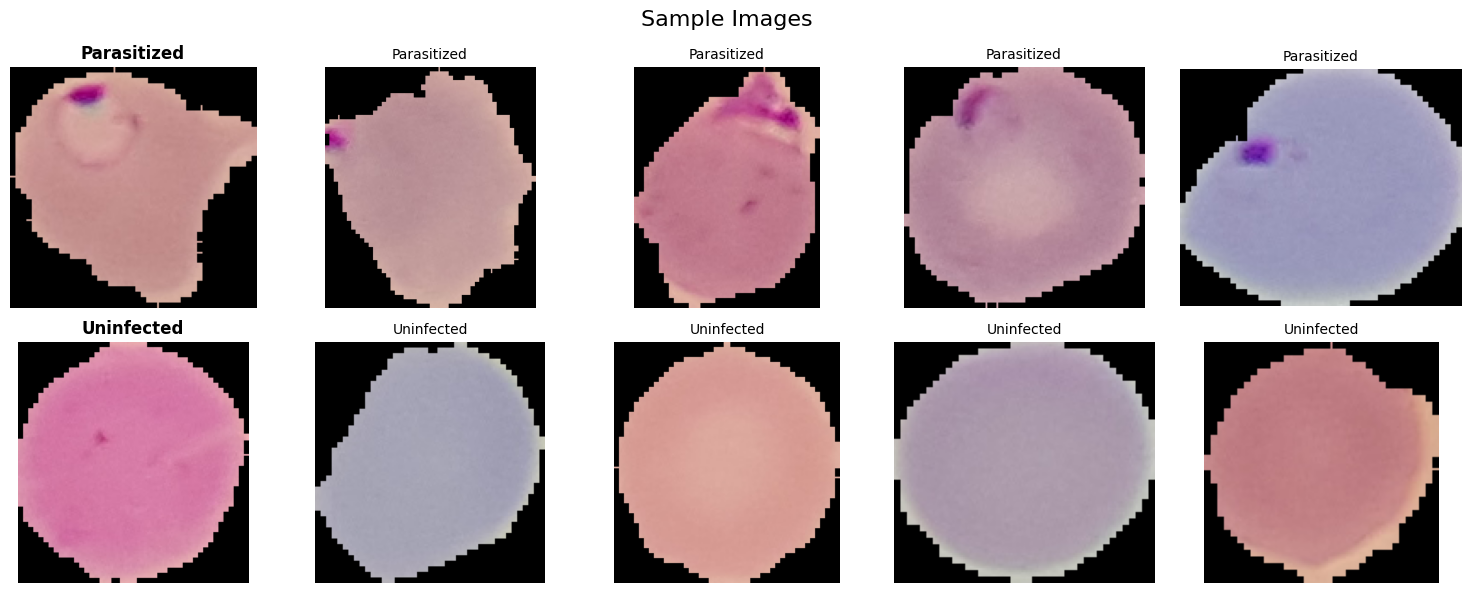

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Images", fontsize=16)


parasitized_samples = os.listdir(os.path.join(split_dirs['train'], 'Parasitized'))[:5]
for i , image_name in enumerate(parasitized_samples):
  image_path = os.path.join(split_dirs['train'], 'Parasitized', image_name)
  image = Image.open(image_path)
  axes[0, i].imshow(image)
  axes[0, i].axis('off')
  if i == 0:
    axes[0, i].set_title('Parasitized', fontweight='bold', fontsize=12)
  else:
    axes[0, i].set_title('Parasitized', fontsize=10)

uninfected_samples = os.listdir(os.path.join(split_dirs['train'], 'Uninfected'))[:5]
for i , image_name in enumerate(uninfected_samples):
  image_path = os.path.join(split_dirs['train'], 'Uninfected', image_name)
  image = Image.open(image_path)
  axes[1, i].imshow(image)
  axes[1, i].axis('off')
  if i == 0:
    axes[1, i].set_title('Uninfected', fontweight='bold', fontsize=12)
  else:
    axes[1, i].set_title('Uninfected', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(Base_dir, 'sample_images.png'), dpi=159, bbox_inches='tight')
plt.show()

## Saving the Dataset Paths and final preparation of the dataset

In [13]:


dataset_info = {
    "base_dir": Base_dir,
    'train_dir': split_dirs['train'],
    'validation_dir': split_dirs['validation'],
    'test_dir': split_dirs['test']
}

import json
with open(os.path.join(Base_dir, 'data_paths.json'), 'w') as f:
  json.dump(dataset_info, f, indent=4)
print("\n" + "="*60)
print("✓ DATA PREPARATION COMPLETE!")
print("="*60)
print(f"\nYour data is ready at: {Base_dir}/")
print("\nDirectory structure:")
print(f"{Base_dir}/")
print("├── train/")
print("│   ├── Parasitized/")
print("│   └── Uninfected/")
print("├── validation/")
print("│   ├── Parasitized/")
print("│   └── Uninfected/")
print("└── test/")
print("    ├── Parasitized/")
print("    └── Uninfected/")

print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
print("1. Use these paths in your baseline CNN notebook:")
print(f"   TRAIN_DIR = '{split_dirs['train']}'")
print(f"   VAL_DIR = '{split_dirs['validation']}'")
print(f"   TEST_DIR = '{split_dirs['test']}'")
print("\n2. Run your baseline CNN training script!")
print("="*60)



✓ DATA PREPARATION COMPLETE!

Your data is ready at: Malaria_data/

Directory structure:
Malaria_data/
├── train/
│   ├── Parasitized/
│   └── Uninfected/
├── validation/
│   ├── Parasitized/
│   └── Uninfected/
└── test/
    ├── Parasitized/
    └── Uninfected/

NEXT STEPS:
1. Use these paths in your baseline CNN notebook:
   TRAIN_DIR = 'Malaria_data/train'
   VAL_DIR = 'Malaria_data/validation'
   TEST_DIR = 'Malaria_data/test'

2. Run your baseline CNN training script!


**This is where the Baseline CNN starts. Data prepation is complete and succesful**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

# Loading dataset paths

if os.path.exists(os.path.join(Base_dir, 'data_paths.json')):
  with open(os.path.join(Base_dir, 'data_paths.json'), 'r') as f:
    dataset_info = json.load(f)
  Train_dir = dataset_info['train_dir']
  Val_dir = dataset_info['validation_dir']
  Test_dir = dataset_info['test_dir']
  print("Loaded paths from data_paths.json")
else:
  print(f"Error: data_paths.json not found in {Base_dir}")


# Verifying directories exist
for dir_name, dir_path in [("Train", Train_dir), ("Validation", Val_dir), ("Test", Test_dir)]:
  if not os.path.exists(dir_path):
    print(f"Error: {dir_name} directory not found at: {dir_path}")

Loaded paths from data_paths.json


In [16]:
# Hyperparameter
image_height = 64
image_width = 64
batch_size = 32
epochs = 20

#this part can be deleted also
print(f"\nHyperparameters:")
print(f"  Image size: {image_height}x{image_width}")
print(f"  Batch size: {batch_size}")
print(f"  Epochs:     {epochs}")

# rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    Val_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False

)

test_generator = test_datagen.flow_from_directory(
    Test_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle=False
)

# this code below can be deleted afterward
print(f"\n✓ Data generators created!")
print(f"  Training samples:   {train_generator.n}")
print(f"  Validation samples: {val_generator.n}")
print(f"  Test samples:       {test_generator.n}")
print(f"  Class indices:      {train_generator.class_indices}")



Hyperparameters:
  Image size: 64x64
  Batch size: 32
  Epochs:     20
Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.

✓ Data generators created!
  Training samples:   19290
  Validation samples: 4134
  Test samples:       4134
  Class indices:      {'Parasitized': 0, 'Uninfected': 1}


In [17]:
def build_baseline_cnn(input_shape=(64, 64, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model instance
baseline_cnn = build_baseline_cnn()

# Model summary
baseline_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

## Data Preparation and Augmentation

In [18]:

Base_dir = "Malaria_data"

train_dir = os.path.join(Base_dir, "train")
val_dir = os.path.join(Base_dir, "validation")
test_dir = os.path.join(Base_dir, "test")

# Parameters
image_height = 224  # MobileNetV2 expects 224x224 images
image_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


##MobileNetV2 Model
I use MobileNetV2 pretrained on ImageNet. Before training i froze the base model layers because it helps reduce overfitting and speeds up training.

In [19]:
def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=1, trainable_layers=20):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze most layers
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


The model uses a standard Conv2D layers for initial feauture extraction,  batch normalization so that thhe training would be accelerated and stabilized. I skipped connections so that I could preserve information.

In [20]:
mobilenet_model = build_mobilenetv2()
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,370,177 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## Training the models
The model starts of at 88% and improves to 94.8% which shows that theirs some learning going on in the training set. The model is recognizing the patterns in the dataset. We can also see that loss reduces from 0.293 to 0.148 which shows the model is minimizing errors. The Validation accuracy stays high and that just means that on unseen data, the model is generalizing well.

The model leanrned quickly and reach a high accuracy and managed to show good generalization.

In [21]:
history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 284s 433ms/step - accuracy: 0.8824 - loss: 0.2953 - val_accuracy: 0.9432 - val_loss: 0.1892
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 231s 383ms/step - accuracy: 0.9347 - loss: 0.1894 - val_accuracy: 0.9507 - val_loss: 0.1531
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 233s 386ms/step - accuracy: 0.9367 - loss: 0.1778 - val_accuracy: 0.9519 - val_loss: 0.1728
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 238s 395ms/step - accuracy: 0.9373 - loss: 0.1752 - val_accuracy: 0.9533 - val_loss: 0.1344
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 401ms/step - accuracy: 0.9428 - loss: 0.1616 - val_accuracy: 0.9555 - val_loss: 0.1316
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 244s 405ms/step - accuracy: 0.9428 - loss: 0.1623 - val_accuracy: 0.9260 - val_loss: 0.2334
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 240s 399ms/step - accuracy: 0.9438 - loss: 0.1569 - val_accuracy: 0.9381 - val_loss: 0.1852
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 234s 388ms/step - accuracy: 0.9428 -

  The MobileNetV2 model performs strongly, its evaluation on the test set acheived a 95% accuracy and a loss of 0.1334. This confirms that the model generalizes well on unseen data nad performed extremely well

In [22]:
test_loss, test_acc = mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

mobilenet_model.save("mobilenetv2_malaria.h5")
print("Model saved successfully!")


130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9608 - loss: 0.1029


Test Accuracy: 0.9560
Model saved successfully!


##Visualizations

Both Training and Validation Accuracy improved steadily over epochs flatlining around 95% accuracy. There was flunctuation eith the validation accuracy but it recovered strongly towards the end. This shows that there is a strong performance without overfitting

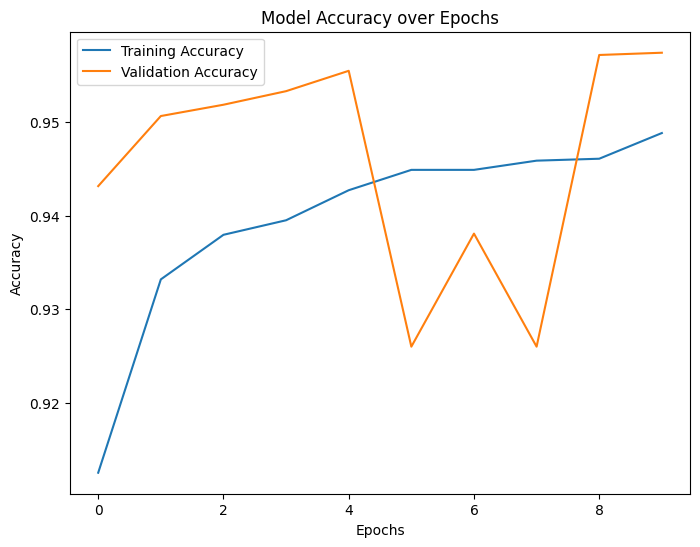

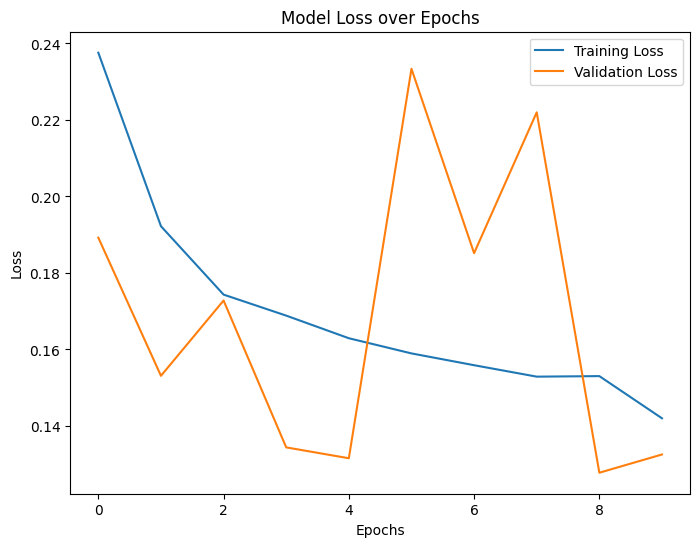

In [23]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Confusion Matrix
The confusion matrix corroborates the accuracy at 95% we can see that clearly if we look at the diagonals the model acheived a high accuracy with majority of both infected and uninfected being labelled accurately

130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step


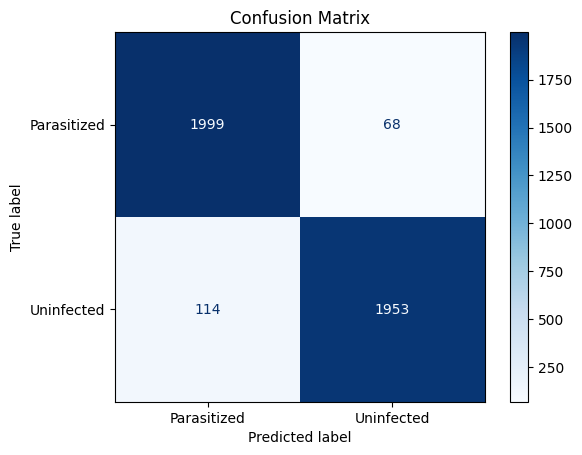

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load model

# Make sure generator is not shuffled
test_generator.reset()

# Get predictions
predictions = mobilenet_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_generator.classes

# Correctly map class labels
class_labels = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


##ROC Curve
The curve shows the trade-off between the True Positive Rate  and the False Positive Rate at different thresholds. The AUC value of 0.992 indicates excellent model performance — the closer the AUC is to 1, the better the model distinguishes between Parasitized and Uninfected cells.

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


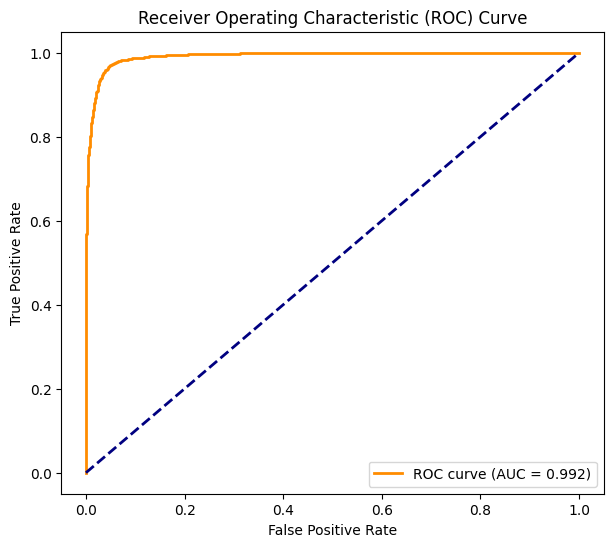

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Make sure test_generator is not shuffled
test_generator.reset()

# Get predictions (probabilities)
predictions = mobilenet_model.predict(test_generator).flatten()  # flatten to 1D

# True labels
true_classes = test_generator.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


##Classification Report
The classsification report summarizes the model performances on the test data. It evaluates the key metrics for each class

Precision - This is how many predicted positives were correct with both parasitized and uninfected having very high scores.

Recall - This is how many actual positives were correctly identified once again the model scored very high scores in both uninfected and paratized.

F1-score is just the balance between both recall and precision. The model scored a 96% from both categories. This shows that the model performs consistently well across both categories.

In [27]:
from sklearn.metrics import classification_report

# Ensure generator is in the correct state
test_generator.reset()

# Get predictions
y_pred = (mobilenet_model.predict(test_generator) > 0.5).astype("int32").flatten()
y_true = test_generator.classes

# Class names
class_names = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
              precision    recall  f1-score   support

 Parasitized       0.95      0.97      0.96      2067
  Uninfected       0.97      0.94      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



##Results and Discussion
The MobileNetV2 classification model acheived a high overall performance on the test dataset.

From the confusion matrix, the model correctly classified most of the samples and only misclassifying a minute portion of the data. The model is also well calibrated with slightly more false negatives than false positives.

The ROC curve also displays an AUC around 0.992 which shows that the model has a strong ability to distinguish between active and healthy cells.

The findings show that MobileNetV2 provides a lightweight but extremely powerful framework for malaria detection.

#Experiments

##Experiment 1
### FineTuning and Augmentation

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    Train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    Train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

model.save('mobilenetv2_malaria_finetuned.keras')


Found 15432 images belonging to 2 classes.
Found 3858 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 286s 548ms/step - accuracy: 0.7711 - loss: 0.4746 - val_accuracy: 0.7157 - val_loss: 0.7327
Epoch 2/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 235s 487ms/step - accuracy: 0.9123 - loss: 0.2399 - val_accuracy: 0.8123 - val_loss: 0.5328
Epoch 3/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 239s 494ms/step - accuracy: 0.9184 - loss: 0.2247 - val_accuracy: 0.8764 - val_loss: 0.3645
Epoch 4/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 236s 488ms/step - accuracy: 0.9272 - loss: 0.2057 - val_accuracy: 0.8994 - val_loss: 0.3094
Epoch 5/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 244s 504ms/step - accuracy: 0.9320 - loss: 0.1957 - val_accuracy: 0.9204 - val_loss: 0.2406
Epoch 6/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 246s 509ms/step - accuracy: 0.9313 - loss: 0.1902 - val_accuracy: 0.9269 - val_loss: 0.1945
Epoch 7/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 244s 506ms/step - accuracy: 0.9306 - loss: 0.1909 - val_accuracy: 0.9248 - val_loss: 0.1957
Epoch 8/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 246s 509ms/step - accuracy: 0.9314 -

130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step


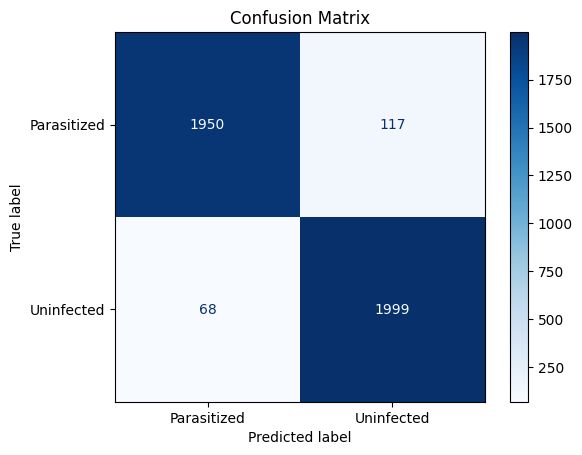

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Make sure generator is not shuffled
test_generator.reset()

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_generator.classes

# Correctly map class labels
class_labels = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step


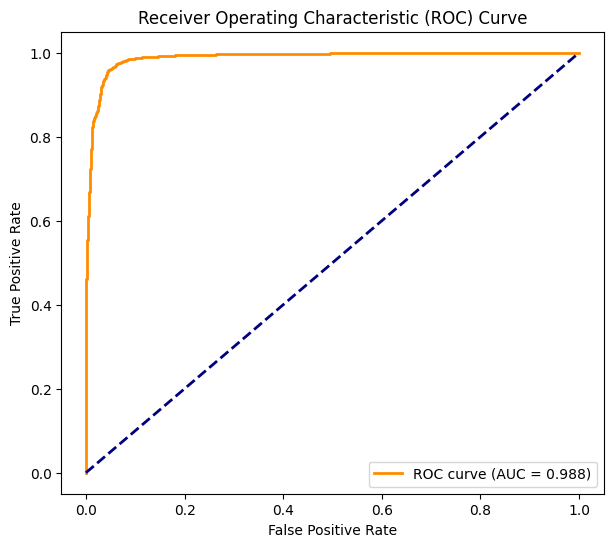

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Make sure test_generator is not shuffled
test_generator.reset()

# Get predictions (probabilities)
predictions = model.predict(test_generator).flatten()  # flatten to 1D

# True labels
true_classes = test_generator.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Interpretation
The model generalizes well after fine-tuning, but shows less accuracy than the baseline, the validation accuracy steadily improved with no overfitting seen. The augmentation helped balance the datasets visual diversity

From the confusion matrix, the model correctly classified most of the samples and only misclassifying a minute portion of the data. The model is also well calibrated with slightly more false positives than false negatives, it still performs less than the baseline.

The ROC curve also displays an AUC around 0.988 which shows that the model has a strong ability to distinguish between active and healthy cells, but will still perform less than the baseline model

The findings show that MobileNetV2 even with the experiment still provides a lightweight framework to detect malaria